In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

class RollingWindowTrainer:
    def __init__(self, train_days=5, test_days=1):
        self.train_days = train_days
        self.test_days = test_days
        self.window_size = train_days + test_days
        self.results = []
        
    def get_day_groups(self, df):
        """Group data by days using datetime index"""
        # Convert index to pandas datetime if it's not already
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
            
        # Get unique days
        return df.groupby(df.index.date)
    
    def optimize_and_train(self, train_data, n_trials=50):
        """Optimize hyperparameters and train model on the given window"""
        # Prepare training data
        X_train = train_data.drop('target', axis=1)
        y_train = train_data['target']
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        def objective(trial):
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 8),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 0.5)
            }
            
            model = xgb.XGBRegressor(**params, random_state=42)
            model.fit(X_train_scaled, y_train)
            
            # Use the last day's data for validation
            last_day_mask = (train_data.index.date == train_data.index.date[-1])
            X_val = X_train_scaled[last_day_mask]
            y_val = y_train[last_day_mask]
            
            val_pred = model.predict(X_val)
            return mean_squared_error(y_val, val_pred, squared=False)  # RMSE
        
        # Optimize
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials)
        
        # Train final model with best parameters
        best_model = xgb.XGBRegressor(**study.best_params, random_state=42)
        best_model.fit(X_train_scaled, y_train)
        
        return best_model, scaler, study.best_value
    
    def run_rolling_window(self, df, n_iterations=3, n_trials=50):
        """Run rolling window analysis for specified number of iterations"""
        self.results = []
        
        # Group data by days
        day_groups = self.get_day_groups(df)
        unique_days = list(day_groups.groups.keys())
        
        for i in range(n_iterations):
            print(f"\nIteration {i+1}/{n_iterations}")
            
            # Get indices for train and test days
            train_start_idx = i
            train_end_idx = train_start_idx + self.train_days
            test_idx = train_end_idx
            
            if test_idx >= len(unique_days):
                print("Reached end of data")
                break
                
            # Get train and test data
            train_days = unique_days[train_start_idx:train_end_idx]
            test_day = unique_days[test_idx]
            
            train_data = pd.concat([day_groups.get_group(day) for day in train_days])
            test_data = day_groups.get_group(test_day)
            
            print(f"Training days: {train_days[0]} to {train_days[-1]}")
            print(f"Test day: {test_day}")
            
            # Train model
            model, scaler, best_val_score = self.optimize_and_train(train_data, n_trials)
            
            # Prepare test data
            X_test = test_data.drop('target', axis=1)
            y_test = test_data['target']
            X_test_scaled = scaler.transform(X_test)
            
            # Make predictions
            predictions = model.predict(X_test_scaled)
            
            # Store results
            for idx, (timestamp, true, pred) in enumerate(zip(test_data.index, y_test, predictions)):
                self.results.append({
                    'iteration': i + 1,
                    'timestamp': timestamp,
                    'date': timestamp.date(),
                    'time': timestamp.time(),
                    'actual': true,
                    'predicted': pred,
                    'train_start': train_days[0],
                    'train_end': train_days[-1],
                    'validation_score': best_val_score
                })
        
        # Convert results to DataFrame
        self.results_df = pd.DataFrame(self.results)
        return self.results_df
    
    def plot_results(self):
        """Plot the results"""
        if not hasattr(self, 'results_df'):
            print("No results to plot. Run rolling_window analysis first.")
            return
            
        # Create figure with multiple subplots
        fig, axes = plt.subplots(3, 1, figsize=(15, 15))
        
        # Plot 1: Actual vs Predicted over time
        axes[0].plot(self.results_df['timestamp'], self.results_df['actual'], 
                    label='Actual', marker='o')
        axes[0].plot(self.results_df['timestamp'], self.results_df['predicted'], 
                    label='Predicted', marker='o')
        
        # Add vertical lines to separate days
        for date in self.results_df['date'].unique():
            axes[0].axvline(x=pd.Timestamp(date), color='gray', linestyle='--', alpha=0.5)
            
        axes[0].set_title('Actual vs Predicted Values Over Time')
        axes[0].legend()
        
        # Plot 2: Prediction Errors
        errors = self.results_df['predicted'] - self.results_df['actual']
        axes[1].plot(self.results_df['timestamp'], errors, marker='o')
        axes[1].axhline(y=0, color='r', linestyle='--')
        axes[1].set_title('Prediction Errors Over Time')
        
        # Plot 3: Validation Scores by Day
        val_scores = self.results_df.groupby('date')['validation_score'].first()
        axes[2].plot(val_scores.index, val_scores.values, marker='o')
        axes[2].set_title('Validation Scores by Day')
        
        plt.tight_layout()
        plt.show()
        
        # Print metrics
        print("\nPerformance Metrics:")
        rmse = np.sqrt(mean_squared_error(self.results_df['actual'], 
                                        self.results_df['predicted']))
        mae = mean_absolute_error(self.results_df['actual'], 
                                self.results_df['predicted'])
        
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        
        # Direction accuracy
        direction_actual = np.sign(self.results_df['actual'])
        direction_pred = np.sign(self.results_df['predicted'])
        direction_accuracy = np.mean(direction_actual == direction_pred)
        print(f"Direction Accuracy: {direction_accuracy:.2%}")
        
        # Print daily metrics
        print("\nDaily Metrics:")
        daily_metrics = self.results_df.groupby('date').agg({
            'actual': lambda x: np.sign(x).mean(),  # Daily trend
            'predicted': lambda x: np.sign(x).mean(),  # Predicted trend
            'validation_score': 'first'
        }).round(4)
        
        print(daily_metrics)

[I 2024-11-06 13:40:46,282] A new study created in memory with name: no-name-7c0c828b-784d-4af9-8165-b0a74146e921
[I 2024-11-06 13:40:46,378] Trial 0 finished with value: 0.13735377415188185 and parameters: {'max_depth': 6, 'learning_rate': 0.02628870865008147, 'n_estimators': 50, 'min_child_weight': 7, 'subsample': 0.6717626620553762, 'colsample_bytree': 0.7137756547841428, 'gamma': 0.23492665492885045}. Best is trial 0 with value: 0.13735377415188185.



Iteration 1/3
Training days: 2023-08-01 to 2023-08-14
Test day: 2023-08-15


[I 2024-11-06 13:40:46,492] Trial 1 finished with value: 0.1452976271114669 and parameters: {'max_depth': 8, 'learning_rate': 0.03313359156547322, 'n_estimators': 157, 'min_child_weight': 6, 'subsample': 0.9588748478077631, 'colsample_bytree': 0.7922024024650794, 'gamma': 0.3539056507812791}. Best is trial 0 with value: 0.13735377415188185.
[I 2024-11-06 13:40:46,576] Trial 2 finished with value: 0.12979666029284 and parameters: {'max_depth': 7, 'learning_rate': 0.06347123675432596, 'n_estimators': 96, 'min_child_weight': 1, 'subsample': 0.6027489041311748, 'colsample_bytree': 0.6133026938600247, 'gamma': 0.26910885869015333}. Best is trial 2 with value: 0.12979666029284.
[I 2024-11-06 13:40:46,772] Trial 3 finished with value: 0.09173596440302592 and parameters: {'max_depth': 8, 'learning_rate': 0.08106023506805307, 'n_estimators': 201, 'min_child_weight': 6, 'subsample': 0.8302191592494791, 'colsample_bytree': 0.781219447034312, 'gamma': 0.120278750899181}. Best is trial 3 with value


Iteration 2/3
Training days: 2023-08-02 to 2023-08-15
Test day: 2023-08-16


[I 2024-11-06 13:40:48,895] Trial 1 finished with value: 0.14313843036815518 and parameters: {'max_depth': 5, 'learning_rate': 0.054194542122948976, 'n_estimators': 59, 'min_child_weight': 4, 'subsample': 0.821443421558451, 'colsample_bytree': 0.9892573341054383, 'gamma': 0.14830814253569163}. Best is trial 1 with value: 0.14313843036815518.
[I 2024-11-06 13:40:49,024] Trial 2 finished with value: 0.16355821976268345 and parameters: {'max_depth': 5, 'learning_rate': 0.07491609892966367, 'n_estimators': 214, 'min_child_weight': 3, 'subsample': 0.9300001413649468, 'colsample_bytree': 0.6893576563578853, 'gamma': 0.2178352759333449}. Best is trial 1 with value: 0.14313843036815518.
[I 2024-11-06 13:40:49,493] Trial 3 finished with value: 0.0149534209976787 and parameters: {'max_depth': 8, 'learning_rate': 0.07506056369386059, 'n_estimators': 137, 'min_child_weight': 5, 'subsample': 0.6517796275710307, 'colsample_bytree': 0.648513923240671, 'gamma': 0.0015917290182532184}. Best is trial 3 


Iteration 3/3
Training days: 2023-08-03 to 2023-08-16
Test day: 2023-08-17


[I 2024-11-06 13:40:51,710] Trial 0 finished with value: 0.13948195326406715 and parameters: {'max_depth': 7, 'learning_rate': 0.016794996555399656, 'n_estimators': 218, 'min_child_weight': 7, 'subsample': 0.7496474267516248, 'colsample_bytree': 0.7888832985883334, 'gamma': 0.13315213194321185}. Best is trial 0 with value: 0.13948195326406715.
[I 2024-11-06 13:40:51,929] Trial 1 finished with value: 0.1800490693924508 and parameters: {'max_depth': 6, 'learning_rate': 0.03351279544747269, 'n_estimators': 109, 'min_child_weight': 6, 'subsample': 0.7146357792624999, 'colsample_bytree': 0.883843770034878, 'gamma': 0.24417071144084318}. Best is trial 0 with value: 0.13948195326406715.
[I 2024-11-06 13:40:52,058] Trial 2 finished with value: 0.18860494482279794 and parameters: {'max_depth': 4, 'learning_rate': 0.03255193034172207, 'n_estimators': 60, 'min_child_weight': 6, 'subsample': 0.9144962358264926, 'colsample_bytree': 0.6040890161036765, 'gamma': 0.1528216938767492}. Best is trial 0 w

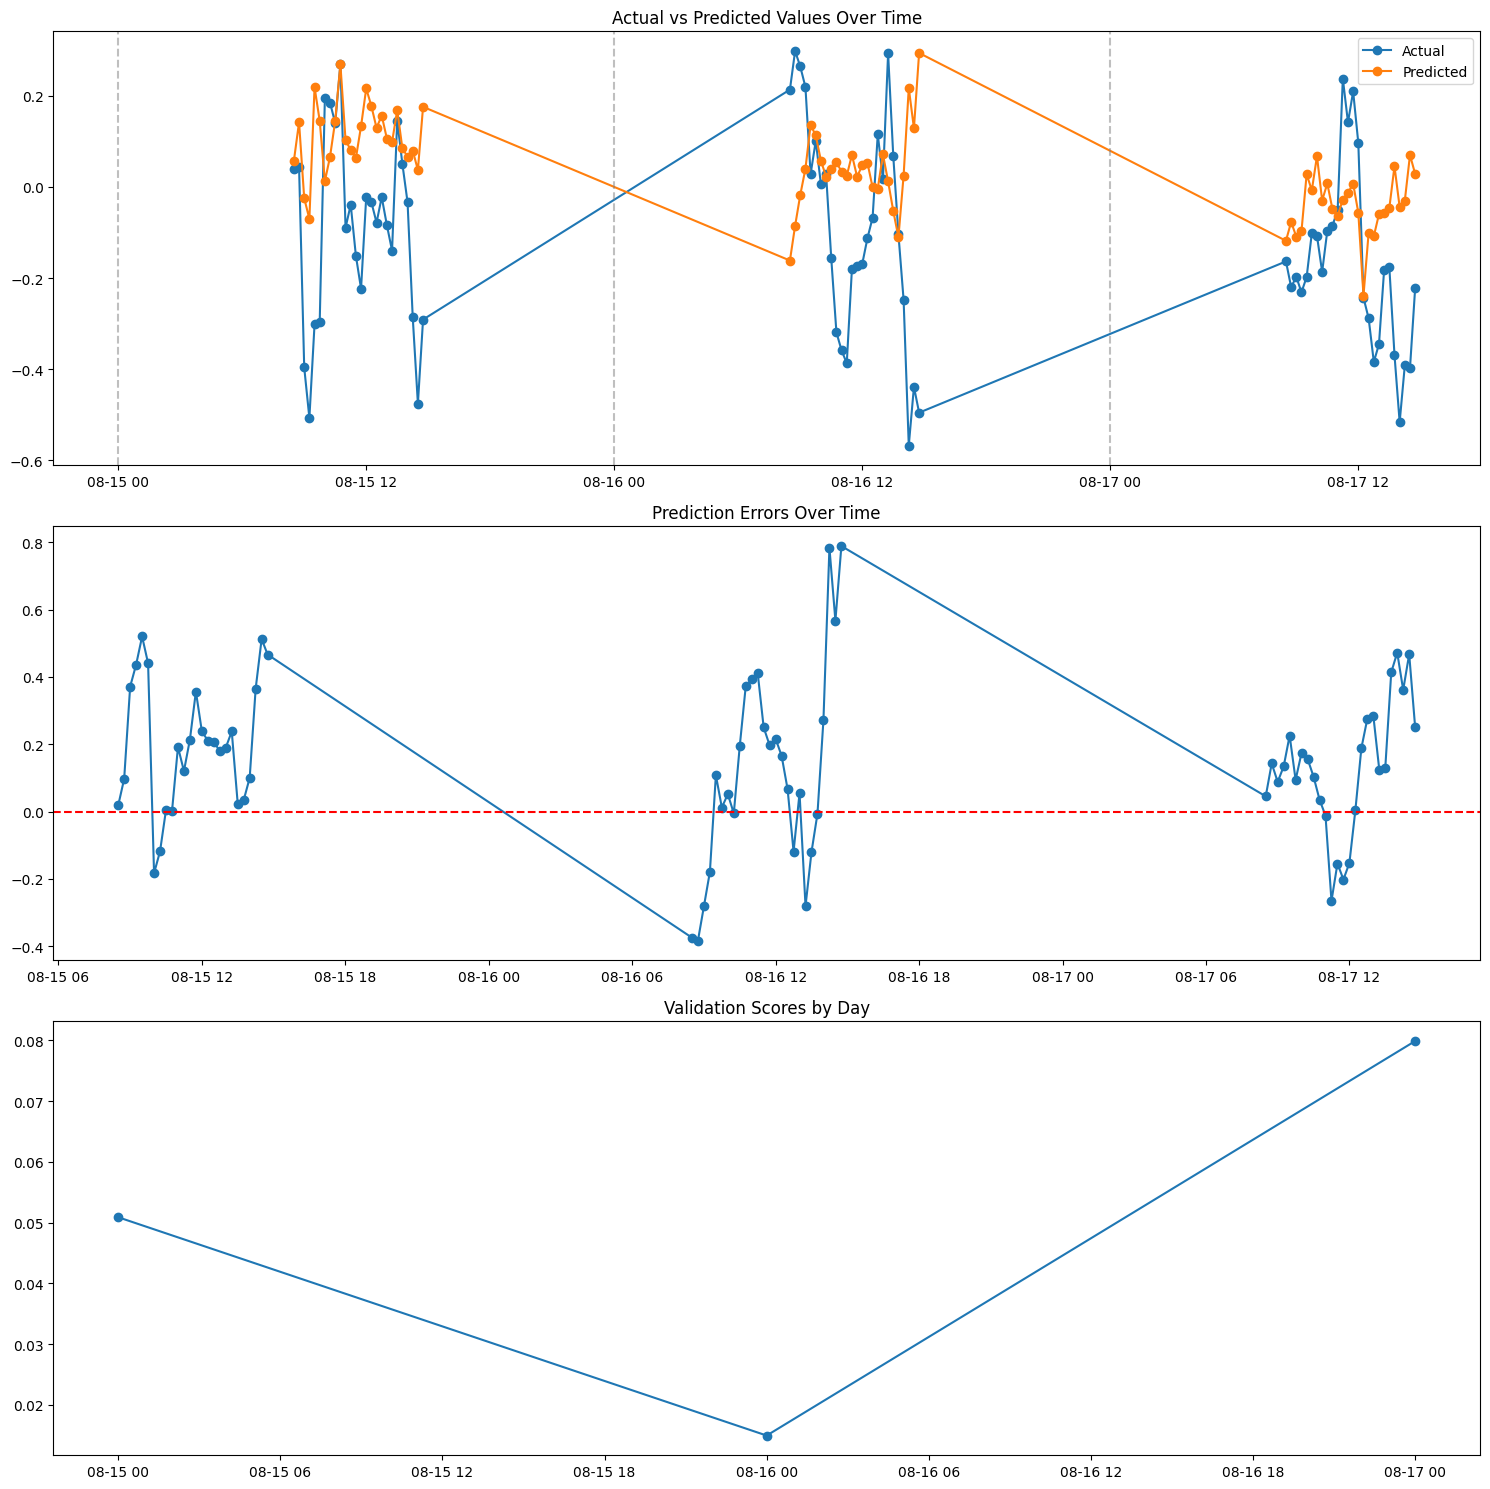


Performance Metrics:
RMSE: 0.2814
MAE: 0.2238
Direction Accuracy: 46.15%

Daily Metrics:
            actual  predicted  validation_score
date                                           
2023-08-15 -0.3846     0.8462            0.0509
2023-08-16 -0.0769     0.4615            0.0150
2023-08-17 -0.6923    -0.4615            0.0799


In [3]:
# Load your data
df = pd.read_csv('model_data.csv', parse_dates=['Open time'])
df.set_index('Open time', inplace=True)

# Initialize trainer
trainer = RollingWindowTrainer(train_days=10, test_days=1)

# Run analysis for 3 iterations
results = trainer.run_rolling_window(df, n_iterations=3, n_trials=10)

# Plot results
trainer.plot_results()